In [22]:
import glob
from torch.utils.data import Dataset, DataLoader
import torch
import os
from PIL import Image
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from torchvision import  models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [23]:
class_names="b1,b2,b3,g1,g2,g3,g4,g5".split(",")
class_names

['b1', 'b2', 'b3', 'g1', 'g2', 'g3', 'g4', 'g5']

In [24]:
spath=r"/kaggle/input/picforkaggleme"##70k

files=glob.glob(os.path.join(spath,"*/*.*"))
files=[x for x in files if "_b" in x or "_g" in x]
files=[x for x in files if not "min" in x ]
files=[x for x in files if "_day" in x ]
files[:11]

['/kaggle/input/picforkaggleme/picforkaggle/002050_b2_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/601225_b1_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/603958_b2_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/600237_b3_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/301058_g4_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/603269_g4_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/300600_g2_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/603808_b3_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/301006_g1_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/002472_g1_day.jpg',
 '/kaggle/input/picforkaggleme/picforkaggle/002736_b3_day.jpg']

In [25]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

In [26]:
def collect_dictionary(obj):
  inv_obj = {}
  for key, value in obj.items():
    inv_obj.setdefault(value, list()).append(key)
  return inv_obj

In [27]:
# lbl2num={"b1":1,"b2":2,"b3":3,"g1":4,"g2":5,"g3":6,"g4":7,"g5":8}
lbl2num={"b1":0,"b2":1,"b3":2,"g1":3,"g2":4,"g3":5,"g4":6,"g5":7}
numtolbl=collect_dictionary(lbl2num)
numtolbl,lbl2num

({0: ['b1'],
  1: ['b2'],
  2: ['b3'],
  3: ['g1'],
  4: ['g2'],
  5: ['g3'],
  6: ['g4'],
  7: ['g5']},
 {'b1': 0, 'b2': 1, 'b3': 2, 'g1': 3, 'g2': 4, 'g3': 5, 'g4': 6, 'g5': 7})

In [28]:
lbl2num["b1"]

0

In [29]:
class MyDataset(Dataset):
    def __init__(self,spathpic,transform=None):
        self.x = self.donepic_(spathpic)
        self.y = self.donepic_lbl(self.x)
        self.len = len(self.x)
        self.transform = transform
        
    def __getitem__(self, index):
        img=self.x[index]## picture filename
        img = Image.open(img).convert('RGB')     # 0~255
        if self.transform is not None:
            img = self.transform(img) 
            
        return img, lbl2num[self.y[index]]

    def __len__(self):
        return self.len

    def donepic_(self,spathpic):
        files=glob.glob(os.path.join(spath,"*/*.*"))
        files=[x for x in files if "_b" in x or "_g" in x]
        files=[x for x in files if "_day" in x ]
        return files

    def donepic_lbl(self,xlist):
        lbllist=[x.split("_")[1] for x in xlist]
        return lbllist

In [30]:
# TRAIN_transforms= transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ])
# train_transform

In [32]:
ds_=MyDataset(spath,transform=train_transform)

from torch.utils.data import random_split
num_train=int(len(ds_)*0.7)##7-3
num_test=len(ds_)-num_train

ds_train,ds_test=random_split(ds_,[num_train,num_test])
# torch.utils.data.random_split


train_ds = DataLoader(dataset=ds_train, batch_size=64, shuffle=False)
test_ds = DataLoader(dataset=ds_test, batch_size=64, shuffle=False)
train_ds

# 划分数据集中时，要对dataset进分划分。
# 不能对DataLoader得到的数据进行划分。
# 划分用torch.utils.data.random_split来划分

In [ ]:
# TRAIN = 'train'
# VAL = 'val'
# TEST = 'test'

# # VGG-16 Takes 224x224 images as input, so we resize all of them
# data_transforms = {
#     TRAIN: transforms.Compose([
#         # Data augmentation is a good practice for the train set
#         # Here, we randomly crop the image to 224x224 and
#         # randomly flip it horizontally. 
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]),
#     VAL: transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]),
#     TEST: transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ])
# }

In [33]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))## rgb change
    plt.figure(figsize=(56, 56))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[x for x in classes])
#     imshow(out, title=[numtolbl[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(train_ds))

In [34]:
# inputs, classes
class_names
num_class=len(class_names)

In [ ]:
# numtolbl,lbl2num

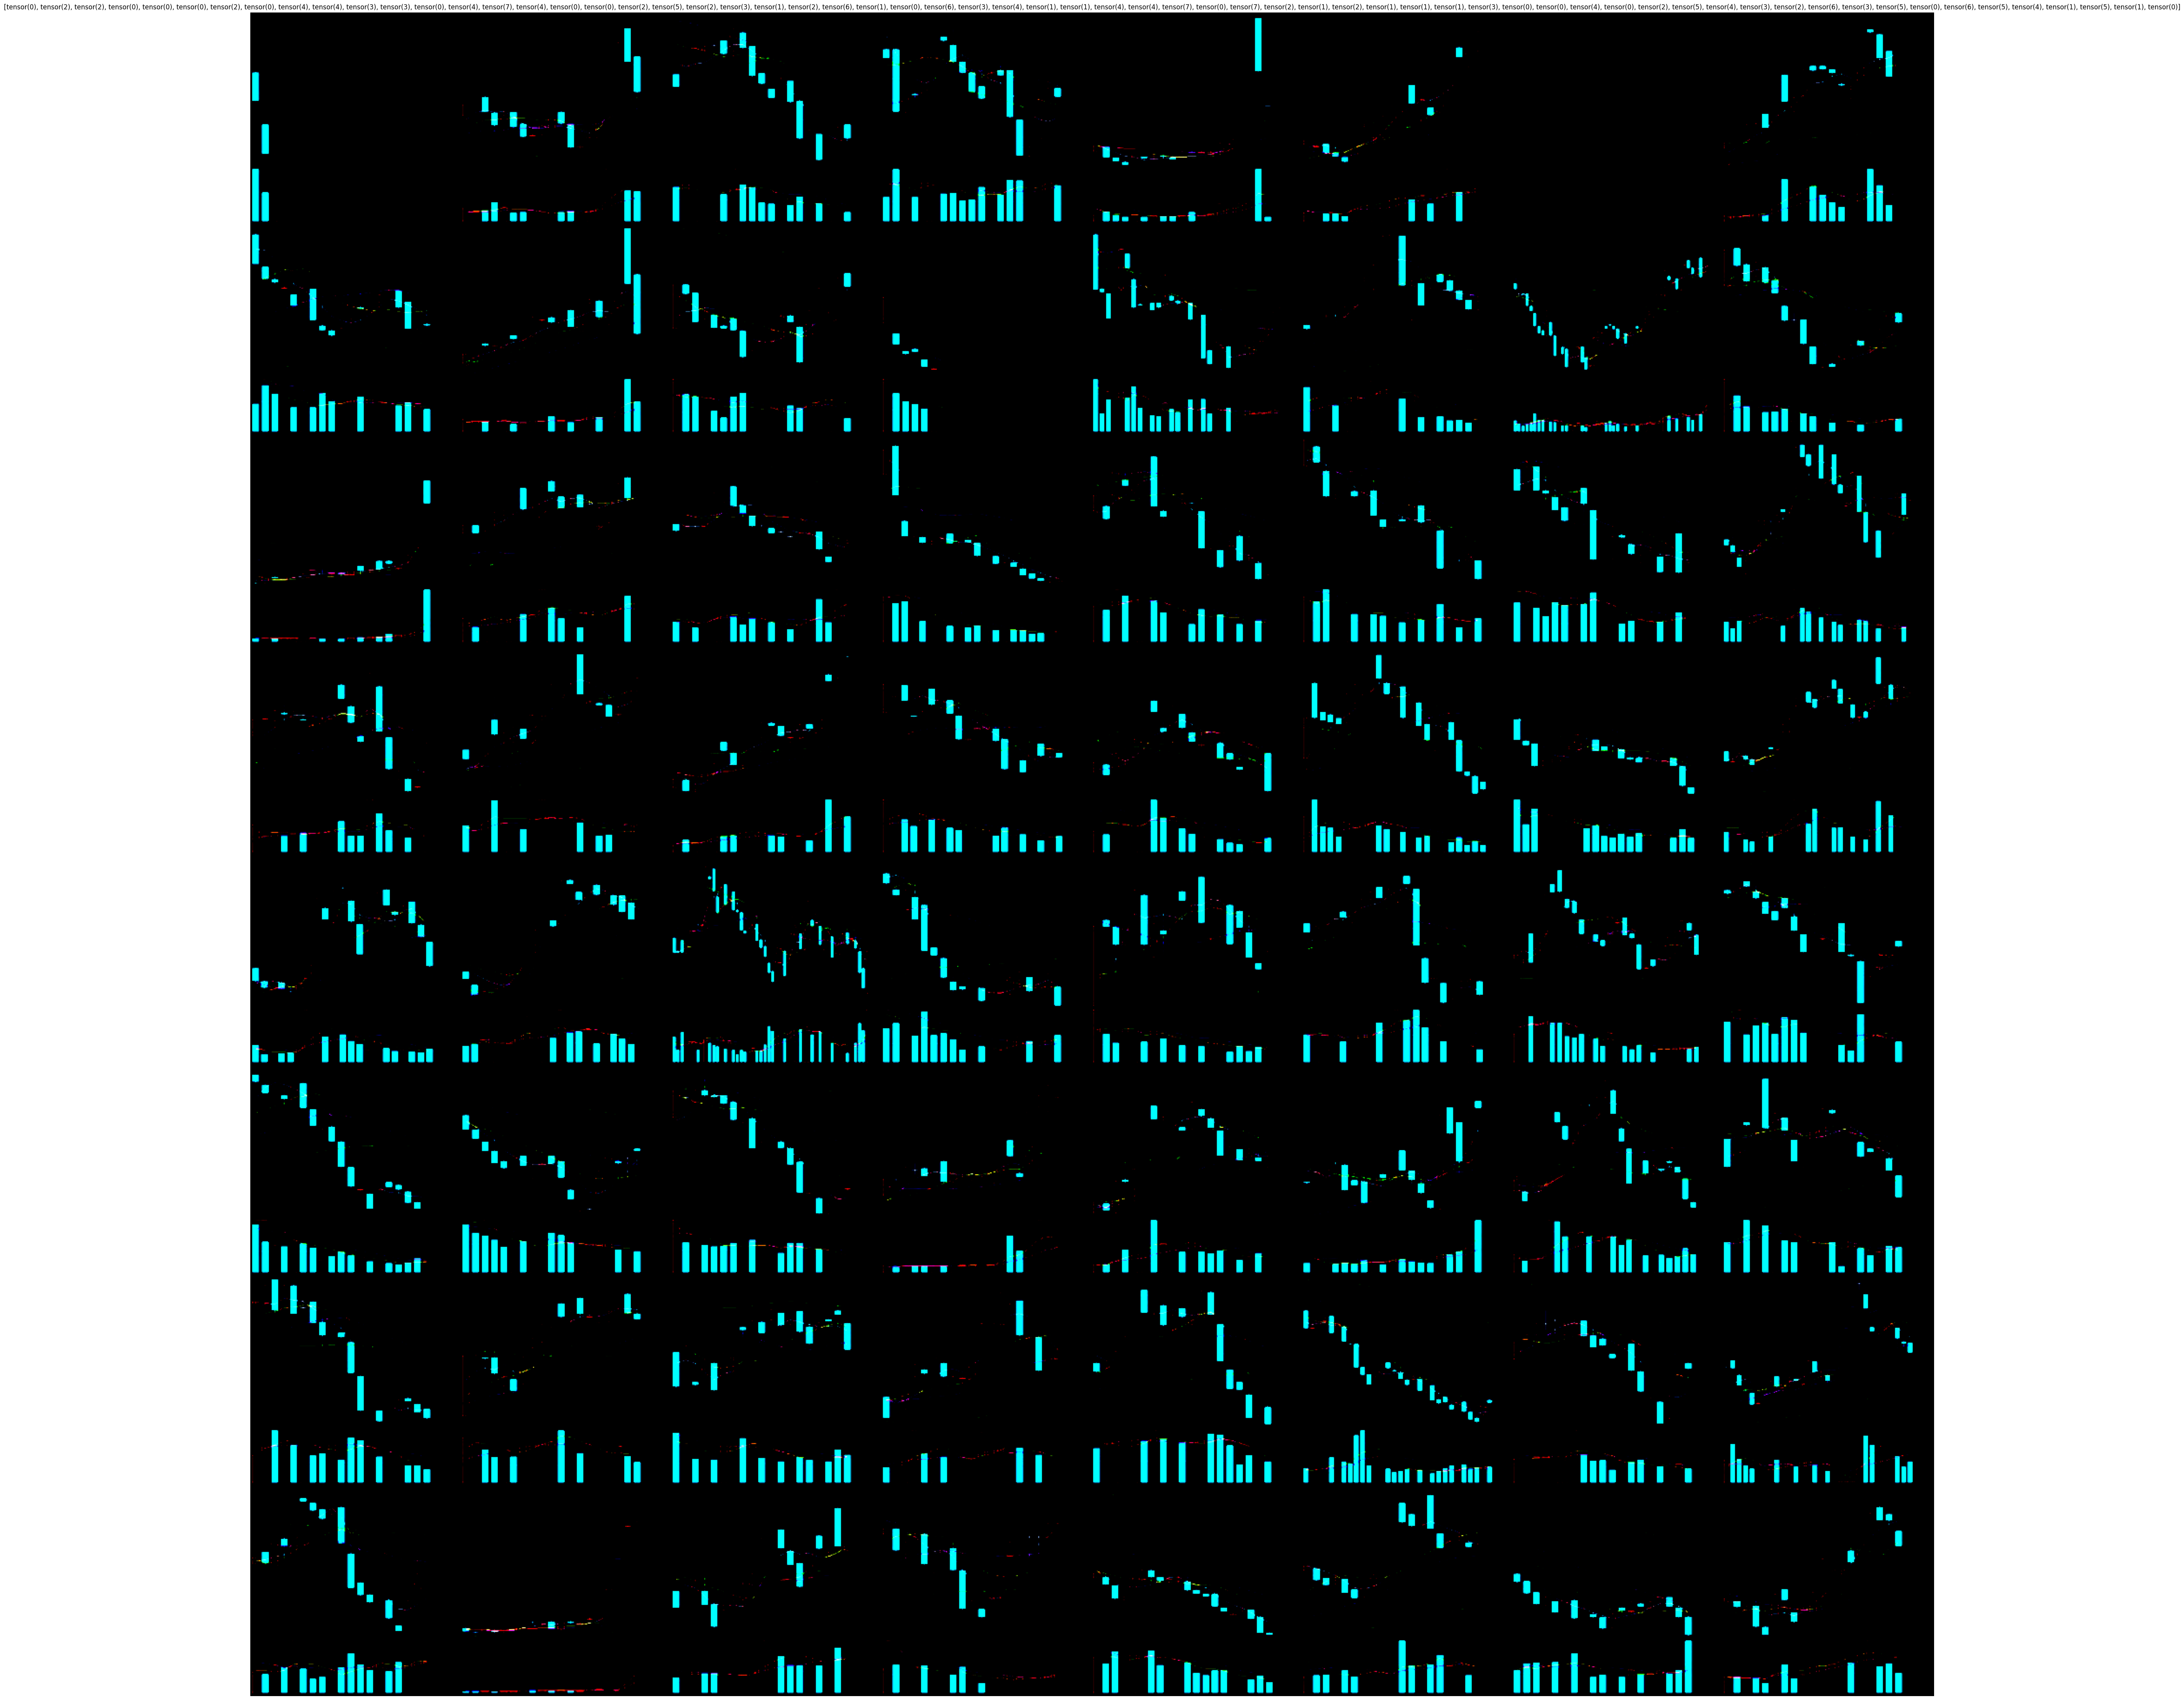

In [35]:
# inputs=list(inputs)
# classes=list(classes)
show_databatch(inputs, classes)

In [ ]:
# # next(iter(train_ds))
# import numpy as np
# inputs, classes = next(iter(train_ds))
# inputs=np.array(inputs)
# classes=np.array(classes)
# # inputs, classes

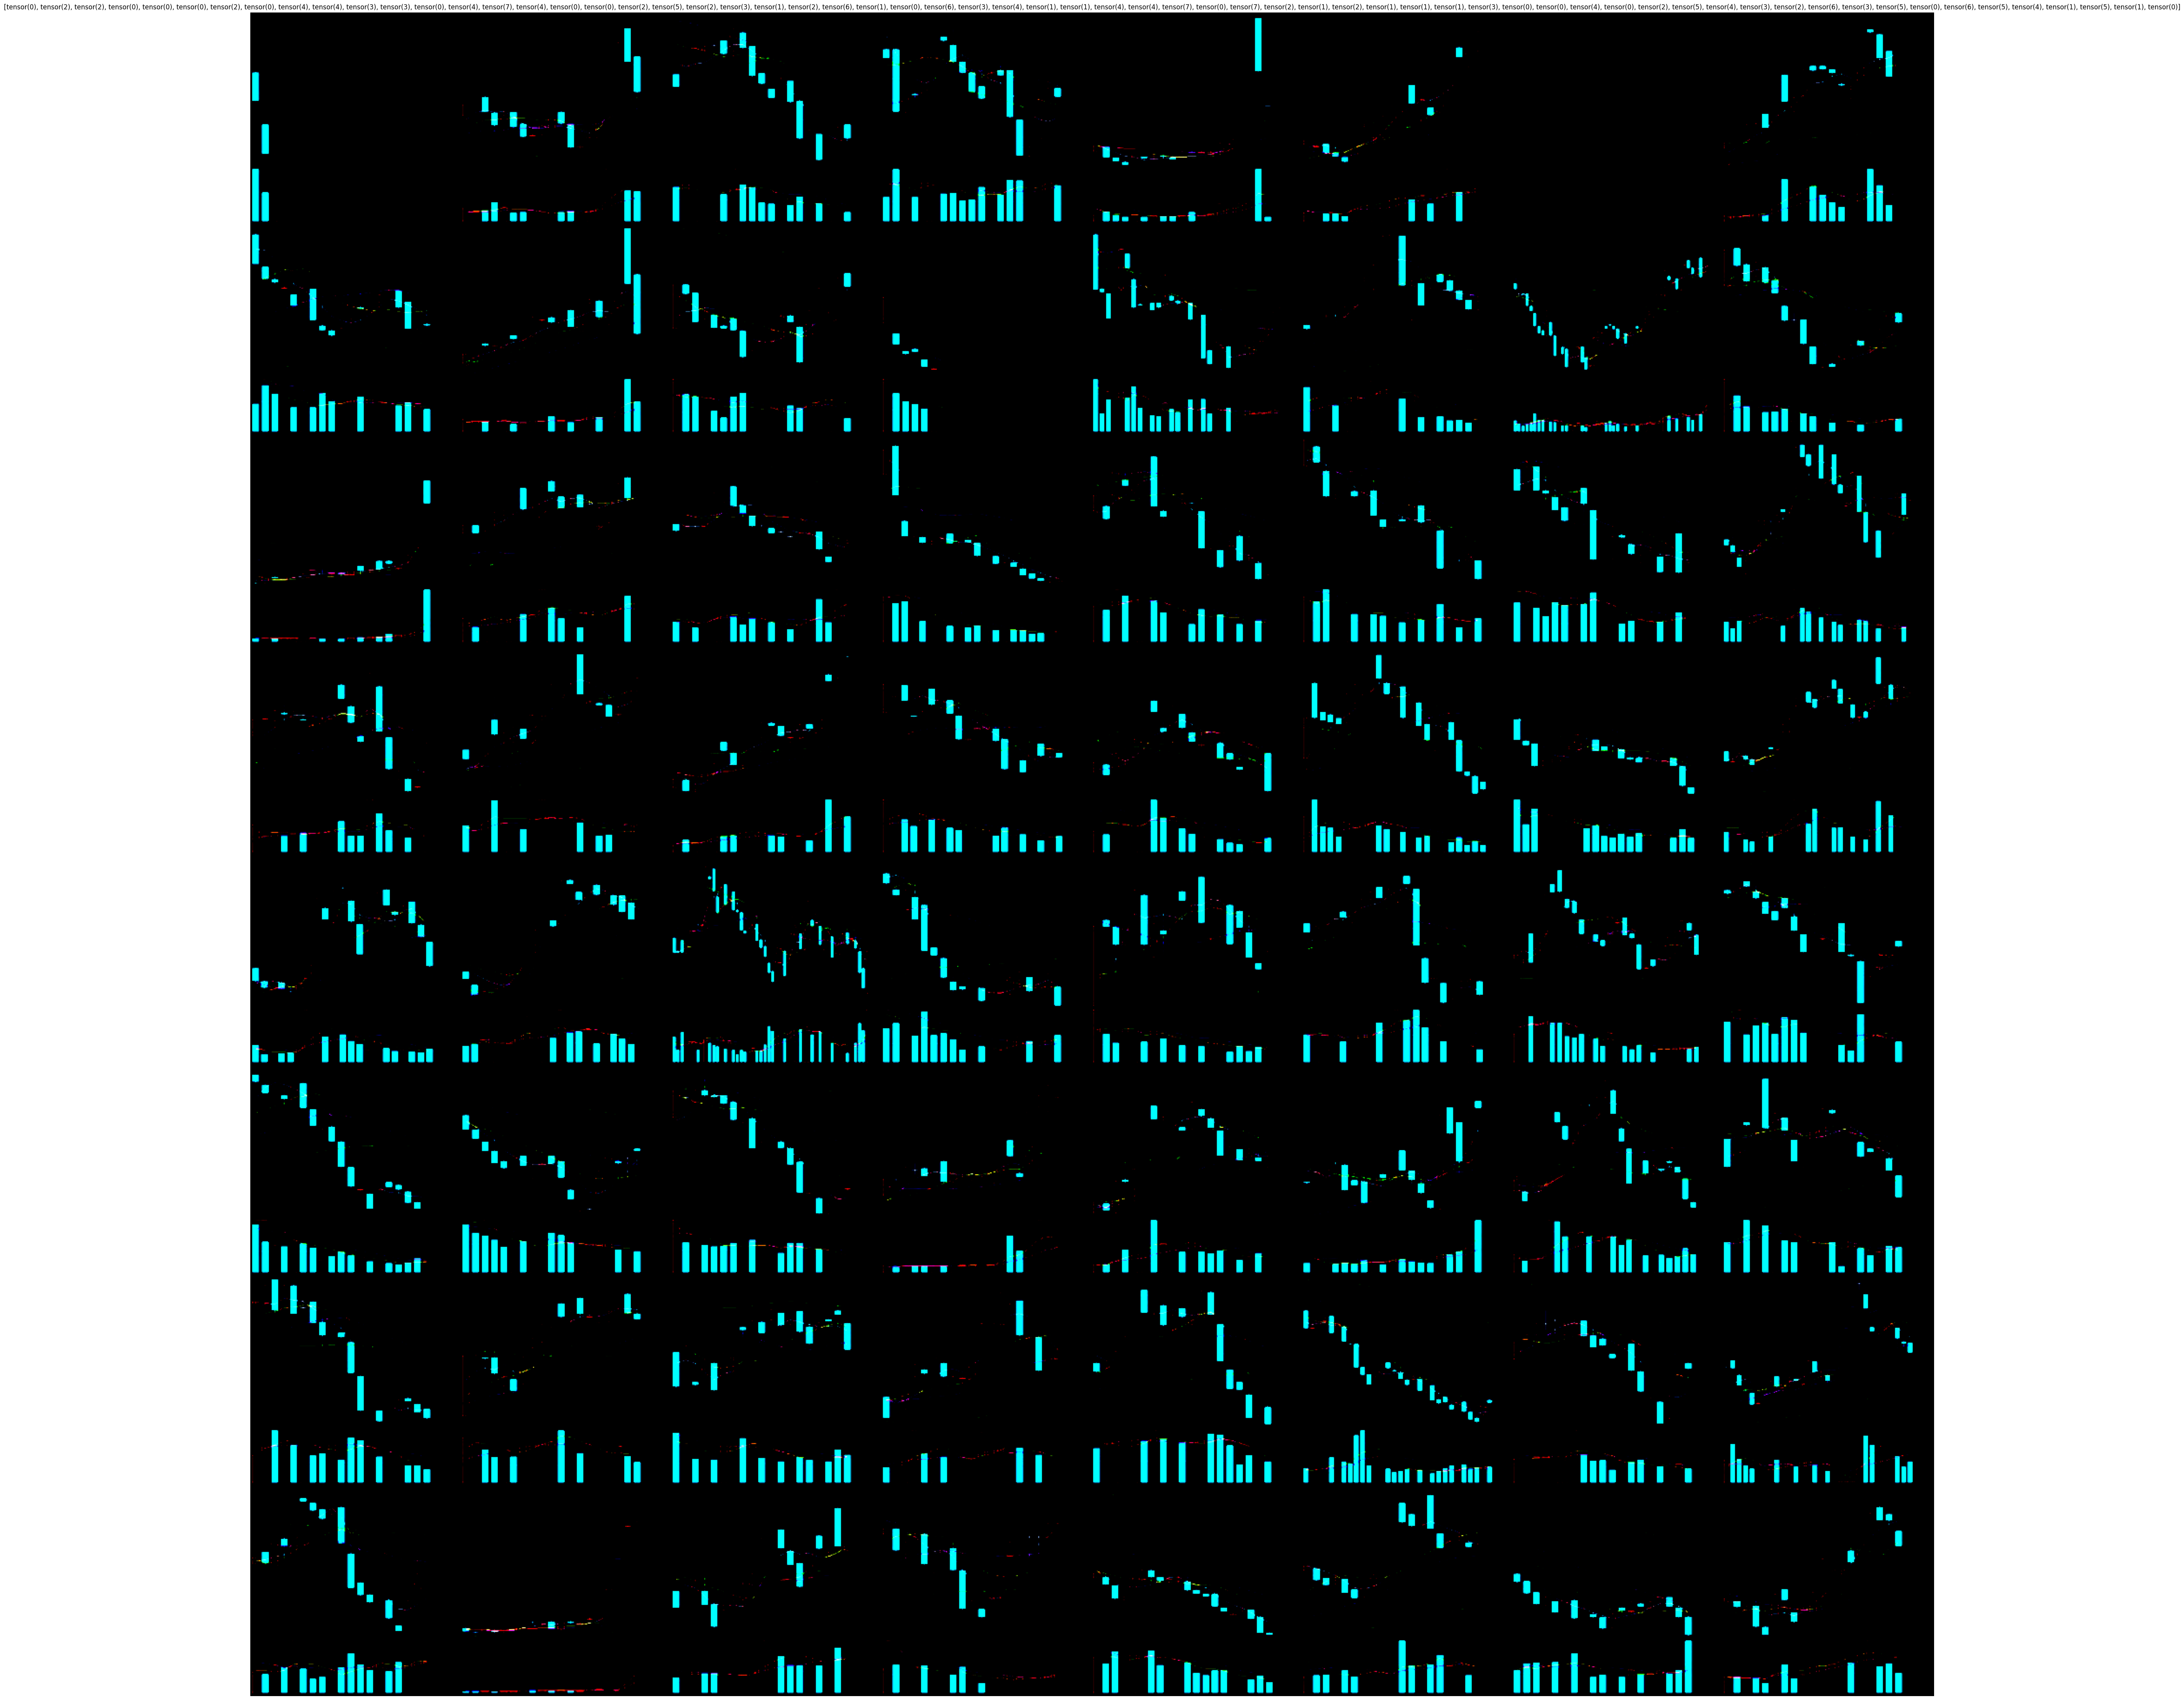

In [36]:
# ds_train
inputs, classes = next(iter(train_ds))
show_databatch(inputs, classes)

DataLoader' object is not subscriptable


如果 dataloader 中没有任何数据,那么 i 就是空的,就会出现 “dataloader” object is not subscriptable 的错误。



为什么会出现这个原因：

是因为 torch的dataset是个可以用 dataset[num] 来iterate的对象

但是torch的dataloader不可以


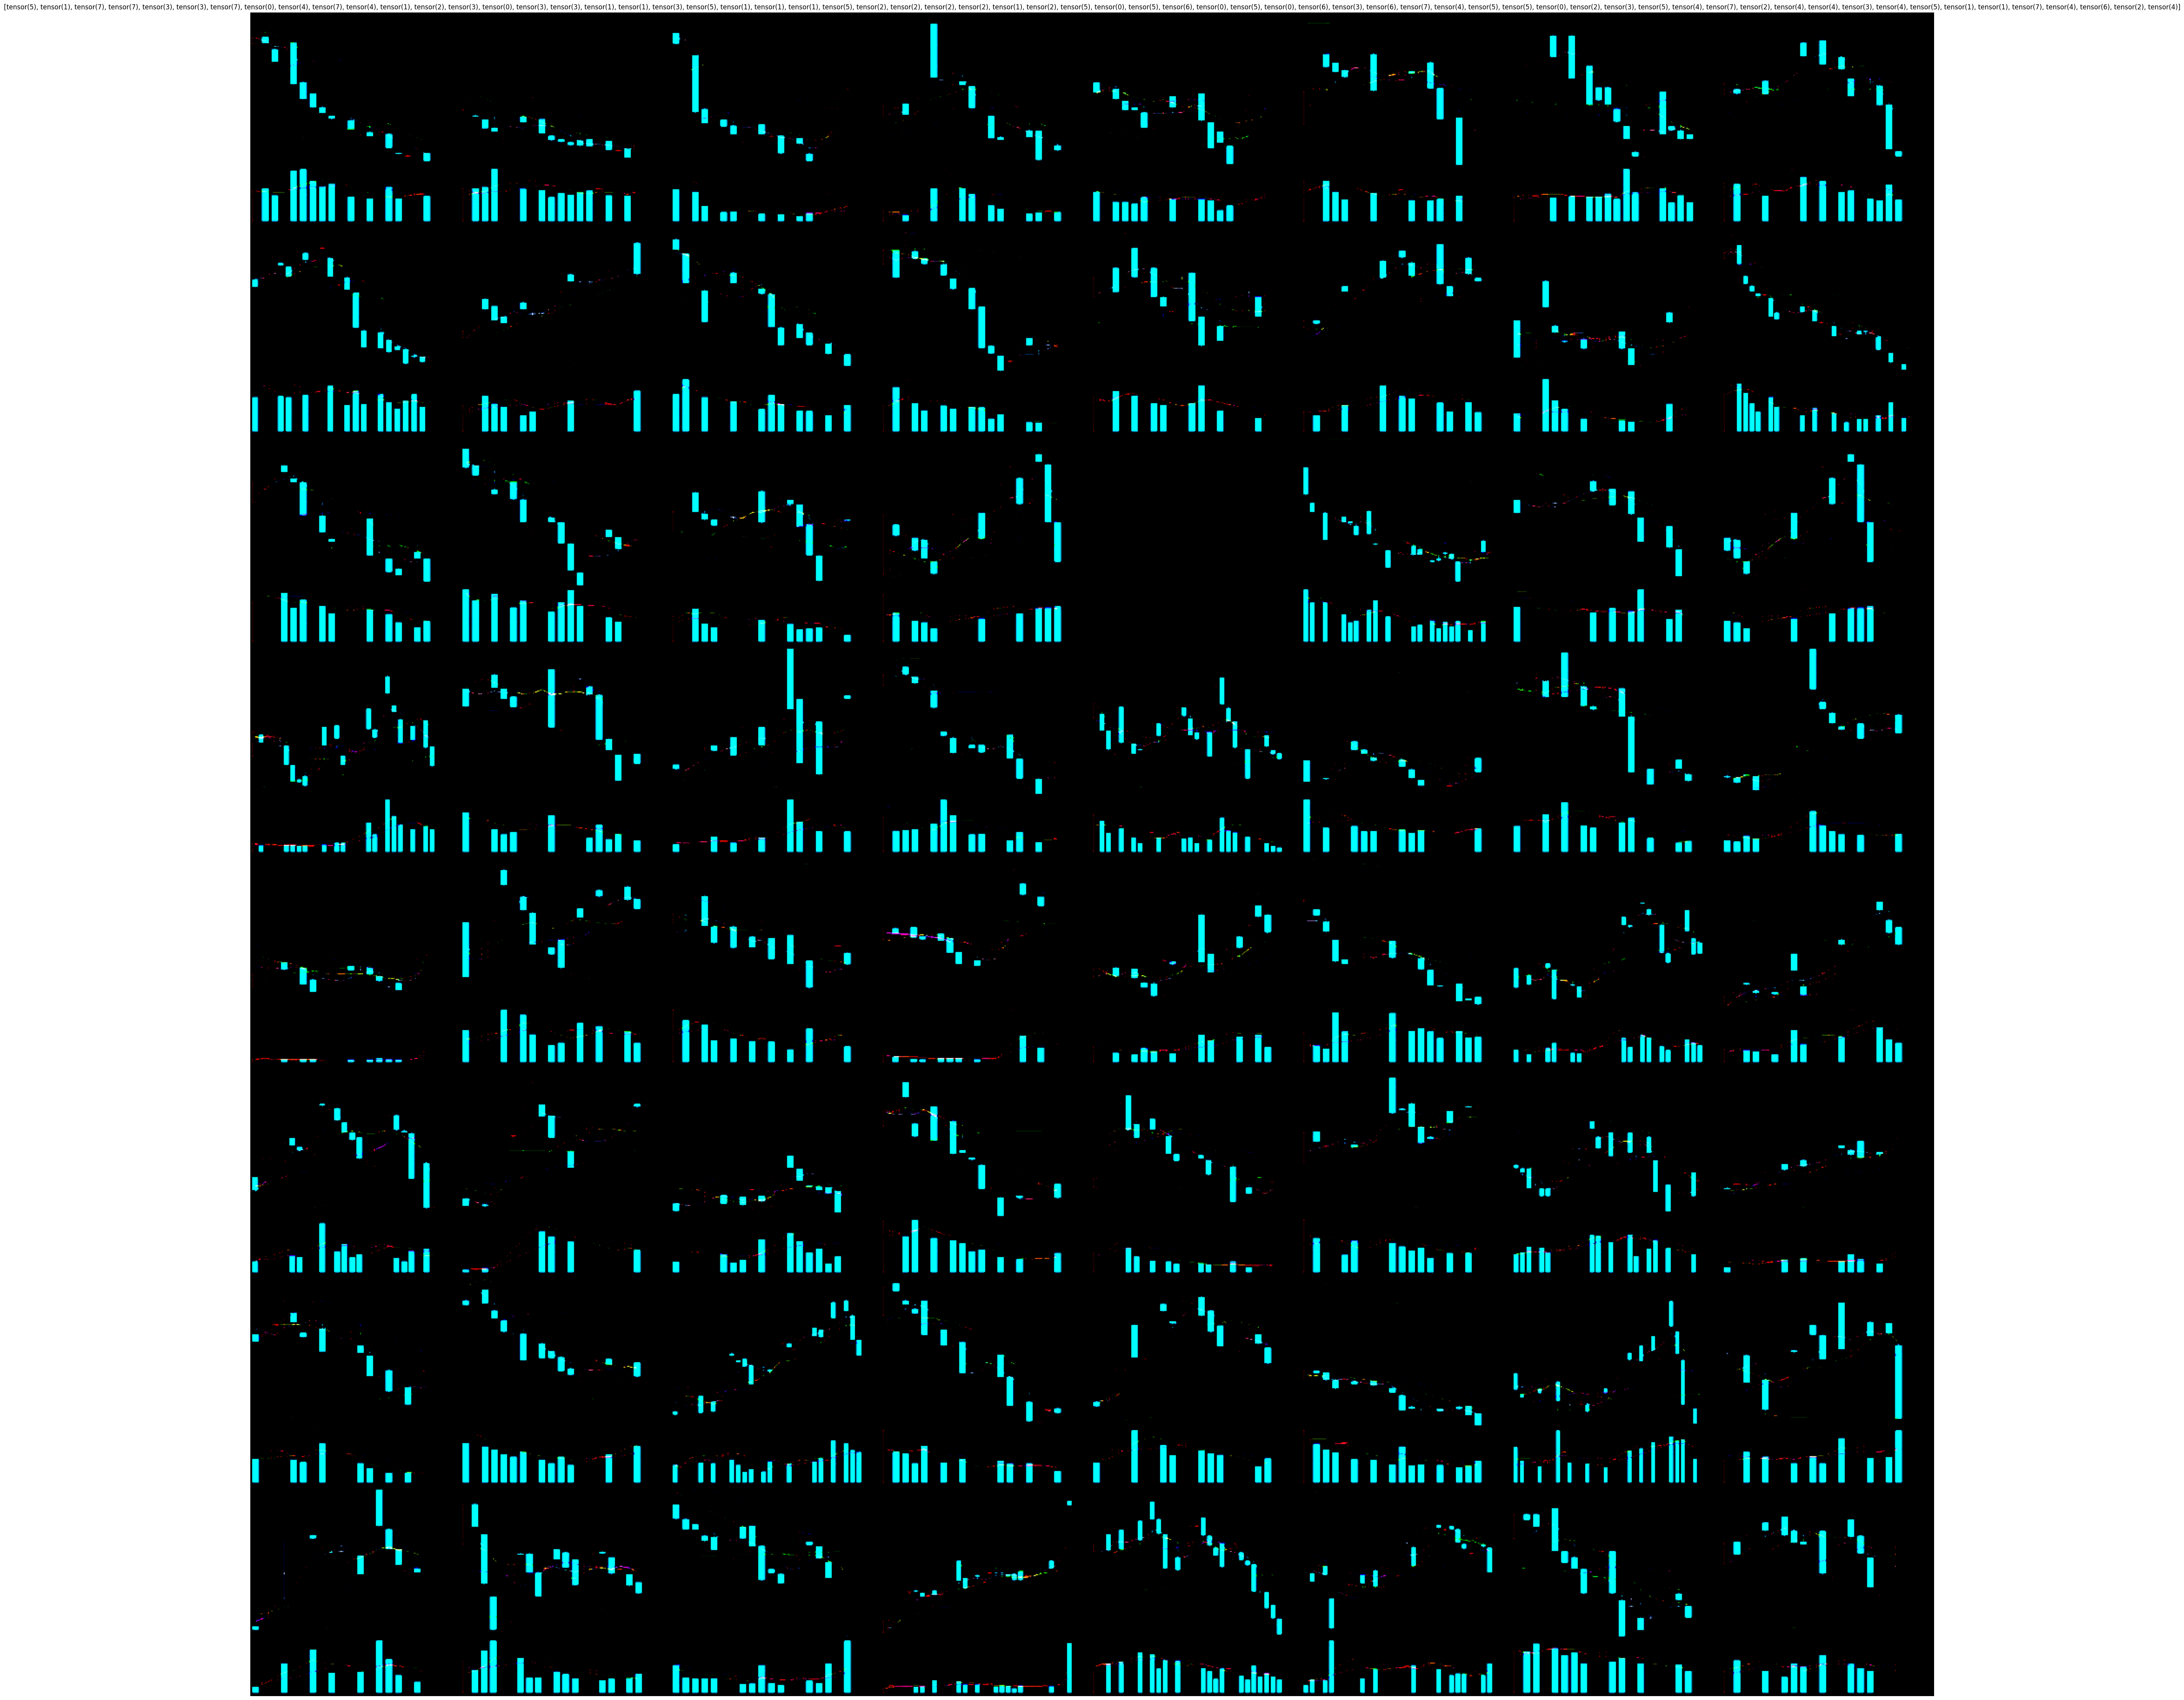

In [37]:
# ds_train
inputs, classes = next(iter(test_ds))
show_databatch(inputs, classes)

In [ ]:
from    torch.nn import functional as F 

In [ ]:
#定义模型
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_class)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model=LeNet()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
ds_train,ds_test

In [ ]:
#开始训练
start_time = time.time()
for epoch in range(5):
    running_loss = 0.0
    for step, data in enumerate(train_ds, 0):
        inputs, labels = data
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        
        if step%500 == 499:
            with torch.no_grad():
                test_outputs = model(test_image)
                predict = torch.max(test_outputs,dim=1)[1]
                accuracy = torch.eq(predict,test_label).sum().item()/test_label.size(0)
                print("[{},{}] train_loss:{} test_acc:{}".format(epoch+1,step+1,running_loss/500,accuracy))
                running_loss=0.0

In [ ]:


end_time = time.time()
total_time = end_time - start_time
print('total_time:{}'.format(total_time))

